In [1]:
import sys,os
sys.path.append(os.pardir)
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
from cmf.crmf import CRMF
%matplotlib inline

In [2]:
dir_path = 'D:/UCI/gas'
file_name = 'ethylene_CO.txt'
file_path = dir_path + '/' + file_name

In [3]:
data = pd.read_csv(file_path, delim_whitespace=True)

In [46]:
gas_columns = list(data.columns[1:3])
used_columns = list(data.columns[3:19])
observable_columns = list(data.columns[3:19:8])
hidden_columns = list(set(used_columns) - set(observable_columns))
gas_column_idxs = [1,2]
observable_column_idxs = [used_columns.index(column_name) for column_name in observable_columns]
hidden_column_idxs = [used_columns.index(column_name) for column_name in hidden_columns]

In [47]:
interval = 200
raw_down_sampled = data[::interval]
m = raw_down_sampled[used_columns].mean(axis = 0)
s = raw_down_sampled[used_columns].std(axis = 0)
down_sampled = pd.DataFrame(raw_down_sampled)
down_sampled[used_columns] = raw_down_sampled[used_columns].sub(m).div(s)

In [48]:
# from statsmodels.stats.diagnostic import acorr_ljungbox
# down_sampled_diff = down_sampled.diff()[1:]
# m = down_sampled_diff.mean(axis=0)
# s = down_sampled_diff.std(axis=0)
# normalized_down_sampled_diff = down_sampled_diff.sub(m).div(s)
# for i in range(19):
#     (b, p) = acorr_ljungbox(normalized_down_sampled_diff[normalized_down_sampled_diff.columns[i]])
#     print(b)
# plt.plot(normalized_down_sampled_diff[:400])

In [64]:
train_data_length = 250000
test_data_length = 250000
train_start_list = [500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000]
test_start_list = [2000000, 2500000, 3000000, 3500000, 500000, 1000000, 1500000]
# train_start_list = [750000]
# test_start_list = [2750000]
regression_window_length_list = [400, 800, 1200, 1600, 2000]
l1_weight_list = [0.038, 0.042, 0.046]
lr_error_table = np.float('nan') * np.ones(len(train_start_list)) 
lrn_error_table = np.float('nan') * np.ones(len(train_start_list)) 
mlr_error_table = np.float('nan') * np.ones([len(regression_window_length_list), len(train_start_list)]) 
mlrn_error_table = np.float('nan') * np.ones([len(regression_window_length_list), len(train_start_list)]) 
crmf_completion_error_table = np.float('nan') * np.ones((len(l1_weight_list), len(train_start_list))) 

In [65]:
for i_start in range(len(train_start_list)):
    train_start = train_start_list[i_start] // interval
    test_start = test_start_list[i_start] // interval
    train_end = train_start + (train_data_length // interval) 
    test_end = test_start + (test_data_length // interval)
    X_train = np.array(down_sampled[observable_columns][train_start:train_end].diff())[1:]
    Y_train = np.array(down_sampled[hidden_columns][train_start:train_end].diff())[1:]
    XY_train = np.array(down_sampled[used_columns][train_start:train_end].diff())[1:]
    F_train = np.ones(XY_train.shape)
    X_test = np.array(down_sampled[observable_columns][test_start:test_end].diff())[1:]
    Y_test = np.array(down_sampled[hidden_columns][test_start:test_end].diff())[1:]
    XY_test = np.array(down_sampled[used_columns][test_start:test_end].diff())[1:]
    F_test = np.zeros(XY_test.shape)
    F_test[:, observable_column_idxs] = 1
    XO_test = XY_test * F_test
    lr = linear_model.LinearRegression()
    lr.fit(X_train, Y_train)
    Y_lr = lr.predict(X_test) 
    lr_error = np.mean((Y_lr - Y_test) ** 2)
    lr_error_table[i_start] = lr_error
    lrn = linear_model.LinearRegression(normalize=True)
    lrn.fit(X_train, Y_train)
    Y_lrn = lrn.predict(X_test) 
    lrn_error = np.mean((Y_lrn - Y_test) ** 2)
    lrn_error_table[i_start] = lrn_error
    for i_regression_window_length in range(len(regression_window_length_list)):
        regression_window_length = regression_window_length_list[i_regression_window_length]
        n_window_samples = regression_window_length // interval
        XX_train = np.concatenate([np.roll(np.array(down_sampled[observable_columns].diff()), i, axis=0) for i in range(-n_window_samples, n_window_samples)], axis = 1)[train_start:train_end, :][1:,:]
        XX_test = np.concatenate([np.roll(np.array(down_sampled[observable_columns].diff()), i, axis=0) for i in range(-n_window_samples, n_window_samples)], axis = 1)[test_start:test_end, :][1:,:]
        mlr = linear_model.LinearRegression()
        mlr.fit(XX_train, Y_train)
        Y_mlr = mlr.predict(XX_test) 
        mlr_error = np.mean((Y_mlr - Y_test) ** 2)
        mlr_error_table[i_regression_window_length, i_start] = mlr_error
        mlrn = linear_model.LinearRegression(normalize=True)
        mlrn.fit(XX_train, Y_train)
        Y_mlrn = mlrn.predict(XX_test) 
        mlrn_error = np.mean((Y_mlrn - Y_test) ** 2)
        mlrn_error_table[i_regression_window_length, i_start] = mlrn_error
    for i_l1_weight in range(len(l1_weight_list)):
        l1_weight = l1_weight_list[i_l1_weight]
        crmf_arg_dict = dict(
            convolution_max = 200,
            true_width = 10000 // interval,
            true_n_components = 2,
            activation_l1_weight = l1_weight,
            activation_l2_weight = 0.0,
            base_max = 10.0,
            convergence_threshold = 0.0000001,
            loop_max = 100,
            fit_accelerator_max = 0.0,
            transfer_accelerator_max = 0.0,
            print_flag = 0,
            initialization = 'smooth_svd')
        crmf = CRMF(**crmf_arg_dict)
#         loss_weight = 1.0 / np.mean(XY_train ** 2, axis=0)
#         base_l2_weight = 1.0 / np.mean(XY_train ** 2, axis=0)
#         base_l1_weight = 0.0 / np.mean(np.abs(XY_train), axis=0)
        loss_weight = 1.0 / np.ones(XY_train.shape[1])
        base_l2_weight = 1.0 / np.ones(XY_train.shape[1])
        base_l1_weight = 0.0 / np.ones(XY_train.shape[1])
        crmf.fit(XY_train, None, filtre = F_train, loss_weight = loss_weight, base_l1_weight = base_l1_weight, base_l2_weight = base_l2_weight)
        crmf.transfer(XO_test, transfer_filtre = F_test)
        XY_crmf = crmf.transfer_approximated
        crmf_completion_error = np.mean(((XY_crmf - XY_test)[:, hidden_column_idxs]) ** 2)
        crmf_completion_error_table[i_l1_weight, i_start] = crmf_completion_error

In [68]:
print(np.mean(lr_error_table))
print(np.mean(mlr_error_table, axis = 1))
print(np.mean(crmf_completion_error_table, axis = 1))


0.00927377851096
[ 0.00918444  0.00911846  0.00917575  0.00926104  0.00934331]
[ 0.00927474  0.00928784  0.00930532]


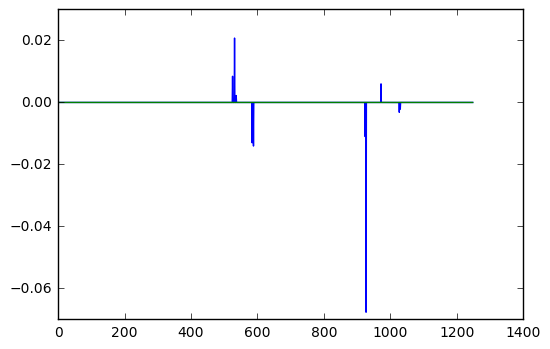

In [69]:
Z = crmf.transfer_activation
plt.plot(Z)

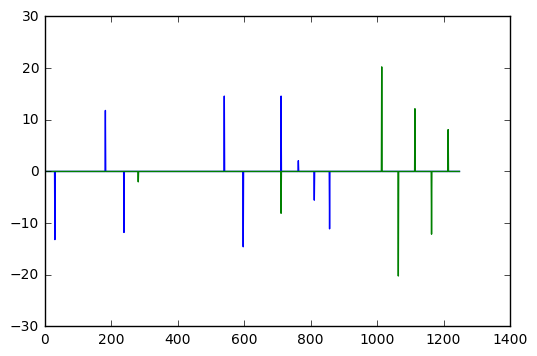

In [32]:
Truth_test = np.array(down_sampled[data.columns[1:3]][test_start:test_end].diff())[1:]
plt.plot(Truth_test / np.std(Truth_test, axis = 0))


In [ ]:
YX = np.array(diff_data[label_columns][train_start:train_end:interval].diff())[1:]
YW = np.array(diff_data[label_columns][test_start:test_end:interval].diff())[1:]
X = np.array(diff_data[used_columns][train_start:train_end:interval].diff())[1:]
W = np.array(diff_data[used_columns][test_start:test_end:interval].diff())[1:]

In [ ]:
F = np.zeros(W.shape)
F[:, observable_column_idxs] = 1

In [ ]:
arg_dict = dict(
    convolution_max = 200,
    true_width = 10000//interval,
    true_n_components = 2,
    activation_l1_weight = 200.0,
    activation_l2_weight = 0.0,
    base_max = 10.0,
    convergence_threshold = 0.0000001,
    loop_max = 100,
    fit_accelerator_max = 0.0,
    transfer_accelerator_max = 0.0,
    print_flag = 0,
    initialization = 'smooth_svd')
crmf = CRMF(**arg_dict)
filtre = np.ones(X.shape)
loss_weight = 1.0 / np.mean(X * X, axis=0)
base_l2_weight = 1.0 / np.mean(X * X, axis=0)
base_l1_weight = 0.0 / np.mean(np.abs(X), axis=0)
factorizer.fit(X, None, filtre=filtre, loss_weight = loss_weight, base_l1_weight = base_l1_weight, base_l2_weight = base_l2_weight)

In [ ]:
crmf.transfer(W, transfer_filtre=F)

In [ ]:
print(np.mean(lr_error_table))
print(np.mean(mlr_error_table, axis = 1))
print(np.mean(crmf_completion_error_table, axis = 1))


In [30]:
Xi = crmf.transfer_approximated
Z = crmf.transfer_activation
completion_error = np.log10(np.sum(((Xi - W)[:, hidden_column_idxs]) ** 2))

NameError: name 'W' is not defined

In [ ]:
plt.plot((Xi/np.mean(np.abs(Xi), axis=0))[:,hidden_column_idxs])
plt.ylim(-50,50)

In [ ]:
plt.plot((W/np.mean(np.abs(W), axis=0))[:, hidden_column_idxs])
plt.ylim(-50,50)

In [ ]:
plt.plot(factorizer.base.transpose(1,0,2)[1,:,:])

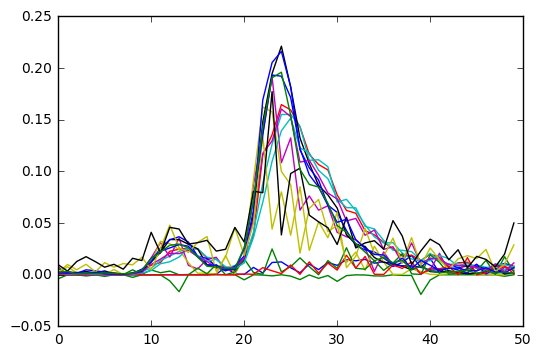

In [29]:
Th = crmf.base
plt.plot(Th.transpose(1,0,2)[0,:,:])


In [ ]:
plt.plot(YW/np.array([10,1]))


In [ ]:
np.log10(np.sum(((factorizer.transfer_approximated - W)[:, hidden_column_idxs]) ** 2))

In [ ]:
plt.plot((XY_test)[:, hidden_column_idxs])

In [ ]:
plt.plot((XY_crmf)[:, hidden_column_idxs])

In [ ]:
plt.plot((Y_mlr))

In [45]:
len(data)

4208261